<a href="https://colab.research.google.com/github/rsj0113/credit_card_transactions_fraud_detection/blob/main/Credit_Card_Transacion_240815.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Kaggle 연동

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"rsj0113","key":"5f31d6c7a8fab20ce630e749e5ecdd46"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# Permission Warning 방지
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d ealtman2019/credit-card-transactions

Dataset URL: https://www.kaggle.com/datasets/ealtman2019/credit-card-transactions
License(s): other
 95% 251M/263M [00:01<00:00, 170MB/s]
100% 263M/263M [00:01<00:00, 165MB/s]


In [ ]:
!unzip -o /content/credit-card-transactions.zip -d /content/input/

Archive:  /content/credit-card-transactions.zip
  inflating: /content/input/User0_credit_card_transactions.csv  
  inflating: /content/input/credit_card_transactions-ibm_v2.csv  
  inflating: /content/input/sd254_cards.csv  
  inflating: /content/input/sd254_users.csv  


In [ ]:
# 파일 확인
!ls

credit-card-transactions.zip  input  kaggle.json  sample_data


# 데이터 LOAD

In [ ]:
## Make sure the lightgbm package is installed
!pip install 'lightgbm'

In [ ]:
## Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector as selector
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, precision_score, recall_score, f1_score

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [ ]:
## Import datasets from Kaggle
df = pd.read_csv('./input/credit_card_transactions-ibm_v2.csv')
user = pd.read_csv('./input/sd254_users.csv')
card = pd.read_csv('./input/sd254_cards.csv')

In [ ]:
df.head()

,User,Card,Year,Month,Day,Time,Amount,Use Chip,Merchant Name,Merchant City,Merchant State,Zip,MCC,Errors?,Is Fraud?
0,0,0,2002,9,1,06:21,$134.09,Swipe Transaction,3527213246127876953,La Verne,CA,91750.0,5300,NaN,No
1,0,0,2002,9,1,06:42,$38.48,Swipe Transaction,-727612092139916043,Monterey Park,CA,91754.0,5411,NaN,No
2,0,0,2002,9,2,06:22,$120.34,Swipe Transaction,-727612092139916043,Monterey Park,CA,91754.0,5411,NaN,No
3,0,0,2002,9,2,17:45,$128.95,Swipe Transaction,3414527459579106770,Monterey Park,CA,91754.0,5651,NaN,No
4,0,0,2002,9,3,06:23,$104.71,Swipe Transaction,5817218446178736267,La Verne,CA,91750.0,5912,NaN,No


In [ ]:
user.head()

,Person,Current Age,Retirement Age,Birth Year,Birth Month,Gender,Address,Apartment,City,State,Zipcode,Latitude,Longitude,Per Capita Income - Zipcode,Yearly Income - Person,Total Debt,FICO Score,Num Credit Cards
0,Hazel Robinson,53,66,1966,11,Female,462 Rose Lane,NaN,La Verne,CA,91750,34.15,-117.76,$29278,$59696,$127613,787,5
1,Sasha Sadr,53,68,1966,12,Female,3606 Federal Boulevard,NaN,Little Neck,NY,11363,40.76,-73.74,$37891,$77254,$191349,701,5
2,Saanvi Lee,81,67,1938,11,Female,766 Third Drive,NaN,West Covina,CA,91792,34.02,-117.89,$22681,$33483,$196,698,5
3,Everlee Clark,63,63,1957,1,Female,3 Madison Street,NaN,New York,NY,10069,40.71,-73.99,$163145,$249925,$202328,722,4
4,Kyle Peterson,43,70,1976,9,Male,9620 Valley Stream Drive,NaN,San Francisco,CA,94117,37.76,-122.44,$53797,$109687,$183855,675,1


In [ ]:
card.head()

,User,CARD INDEX,Card Brand,Card Type,Card Number,Expires,CVV,Has Chip,Cards Issued,Credit Limit,Acct Open Date,Year PIN last Changed,Card on Dark Web
0,0,0,Visa,Debit,4344676511950444,12/2022,623,YES,2,$24295,09/2002,2008,No
1,0,1,Visa,Debit,4956965974959986,12/2020,393,YES,2,$21968,04/2014,2014,No
2,0,2,Visa,Debit,4582313478255491,02/2024,719,YES,2,$46414,07/2003,2004,No
3,0,3,Visa,Credit,4879494103069057,08/2024,693,NO,1,$12400,01/2003,2012,No
4,0,4,Mastercard,Debit (Prepaid),5722874738736011,03/2009,75,YES,1,$28,09/2008,2009,No


# 데이터 EDA

## df

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24386900 entries, 0 to 24386899
Data columns (total 15 columns):
 #   Column          Dtype  
---  ------          -----  
 0   User            int64  
 1   Card            int64  
 2   Year            int64  
 3   Month           int64  
 4   Day             int64  
 5   Time            object 
 6   Amount          object 
 7   Use Chip        object 
 8   Merchant Name   int64  
 9   Merchant City   object 
 10  Merchant State  object 
 11  Zip             float64
 12  MCC             int64  
 13  Errors?         object 
 14  Is Fraud?       object 
dtypes: float64(1), int64(7), object(7)
memory usage: 2.7+ GB


In [ ]:
df[['User', 'Is Fraud?']].groupby('Is Fraud?').count()

,User
Is Fraud?,
No,24357143
Yes,29757


In [ ]:
df['User'].nunique()

2000

In [ ]:
df[['User', 'Is Fraud?']].groupby('User').count()

,Is Fraud?
User,
0,19963
1,8919
2,41978
3,10117
4,18542
...,...
1995,14713
1996,18012
1997,21607


In [ ]:
df [df['Is Fraud?'] == 'Yes']

,User,Card,Year,Month,Day,Time,Amount,Use Chip,Merchant Name,Merchant City,Merchant State,Zip,MCC,Errors?,Is Fraud?
4099,0,0,2015,11,15,12:55,$287.13,Online Transaction,-8194607650924472520,ONLINE,NaN,NaN,3001,NaN,Yes
4100,0,0,2015,11,15,13:19,$2.41,Online Transaction,-7759074308363763111,ONLINE,NaN,NaN,5651,NaN,Yes
4101,0,0,2015,11,16,09:41,$50.81,Online Transaction,-551332107213382088,ONLINE,NaN,NaN,4411,NaN,Yes
4102,0,0,2015,11,16,09:46,$248.36,Online Transaction,4872340518840476610,ONLINE,NaN,NaN,5732,NaN,Yes
4103,0,0,2015,11,16,11:20,$473.00,Online Transaction,-8566951830324093739,ONLINE,NaN,NaN,3640,NaN,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24375668,1997,2,2016,9,4,10:45,$1.25,Online Transaction,6455213054093379528,ONLINE,NaN,NaN,5815,NaN,Yes
24375670,1997,2,2016,9,4,12:30,$116.66,Online Transaction,822647939787511611,ONLINE,NaN,NaN,5311,NaN,Yes
24375671,1997,2,2016,9,4,12:40,$359.99,Online Transaction,8080934608468946743,ONLINE,NaN,NaN,5310,NaN,Yes
24375672,1997,2,2016,9,4,13:45,$351.51,Online Transaction,-4282466774399734331,ONLINE,NaN,NaN,4829,NaN,Yes


In [ ]:
df [df['Is Fraud?'] == 'Yes'][['Year','User']].groupby('Year').count()

,User
Year,
1996,10
1997,32
1998,32
1999,24
2000,171
2001,354
2002,139
2003,311
2004,620


In [ ]:
df[['User', 'Is Fraud?', 'Amount']].groupby(['User', 'Is Fraud?']).count()

Amount
User Is Fraud?        
0    No          19936
     Yes            27
1    No           8886
     Yes            33
2    No          41934
...                ...
1996 Yes            50
1997 No          21587
     Yes            20
1998 No           5782
1999 No           4761

[3343 rows x 1 columns]

In [ ]:
df[['User', 'Card', 'Amount']].groupby(['User', 'Card']).count()

Amount
User Card        
0    0       5011
     1       1203
     2       4332
     3       9391
     4         26
...           ...
1997 1      15208
     2       3232
1998 0       5782
1999 0         87
     1       4674

[6139 rows x 1 columns]

(array([417., 388., 451., 373.,   0., 207., 105.,  39.,  17.,   3.]),
 array([1. , 1.8, 2.6, 3.4, 4.2, 5. , 5.8, 6.6, 7.4, 8.2, 9. ]),
 <BarContainer object of 10 artists>)

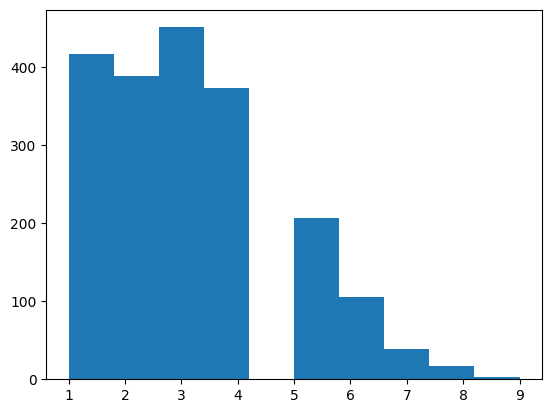

In [ ]:
plt.hist(df.groupby('User')['Card'].nunique())

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
 [Text(0, 0, 'Errors?'),
  Text(1, 0, 'Zip'),
  Text(2, 0, 'Merchant State'),
  Text(3, 0, 'User'),
  Text(4, 0, 'Card'),
  Text(5, 0, 'Year'),
  Text(6, 0, 'Month'),
  Text(7, 0, 'Day'),
  Text(8, 0, 'Time'),
  Text(9, 0, 'Amount'),
  Text(10, 0, 'Use Chip'),
  Text(11, 0, 'Merchant Name'),
  Text(12, 0, 'Merchant City'),
  Text(13, 0, 'MCC'),
  Text(14, 0, 'Is Fraud?')])

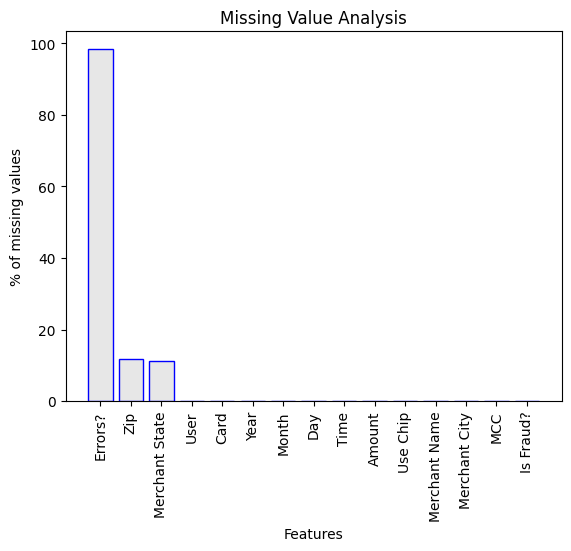

In [ ]:
percent_missing=(df.isnull().sum()*100/df.shape[0]).sort_values(ascending=True)
plt.title("Missing Value Analysis")
plt.xlabel("Features")
plt.ylabel("% of missing values")
plt.bar(percent_missing.sort_values(ascending=False).index,percent_missing.sort_values(ascending=False),color=(0.1, 0.1, 0.1, 0.1),edgecolor='blue')
plt.xticks(rotation=90)

In [ ]:
# df["card_id"] = df["User"].astype(str) + "_" + df["Card"].astype(str)

In [ ]:
df.Amount.head(5)

,Amount
0,$134.09
1,$38.48
2,$120.34
3,$128.95
4,$104.71


In [ ]:
# df["Amount"]=df["Amount"].str.replace("$","").astype(float)

In [ ]:
# df.Amount.head(5)

In [ ]:
# df["Hour"] = df["Time"].str [0:2]
# df["Minute"] = df["Time"].str [3:5]

In [ ]:
# df.Hour

In [ ]:
# df.Minute

In [ ]:
# df = df.drop(["Time","User","Card"],axis=1)
# df.info()

In [ ]:
df["Errors?"].unique()

array([nan, 'Technical Glitch', 'Insufficient Balance', 'Bad PIN',
       'Bad PIN,Insufficient Balance', 'Bad Expiration',
       'Bad PIN,Technical Glitch', 'Bad Card Number', 'Bad CVV',
       'Bad Zipcode', 'Insufficient Balance,Technical Glitch',
       'Bad Card Number,Insufficient Balance', 'Bad Card Number,Bad CVV',
       'Bad CVV,Insufficient Balance', 'Bad Card Number,Bad Expiration',
       'Bad Expiration,Bad CVV', 'Bad Expiration,Insufficient Balance',
       'Bad Expiration,Technical Glitch',
       'Bad Card Number,Bad Expiration,Technical Glitch',
       'Bad CVV,Technical Glitch', 'Bad Card Number,Technical Glitch',
       'Bad Zipcode,Insufficient Balance', 'Bad Zipcode,Technical Glitch',
       'Bad Card Number,Bad Expiration,Insufficient Balance'],
      dtype=object)

In [ ]:
# df["Errors?"]= df["Errors?"].fillna("No error")

In [ ]:
# df.head()

(array([1.2087e+04, 8.0100e+02, 3.4000e+02, 8.3000e+01, 5.4000e+01,
        3.1000e+01, 2.1000e+01, 4.0000e+00, 6.0000e+00, 2.0000e+00]),
 array([ 0. ,  2.5,  5. ,  7.5, 10. , 12.5, 15. , 17.5, 20. , 22.5, 25. ]),
 <BarContainer object of 10 artists>)

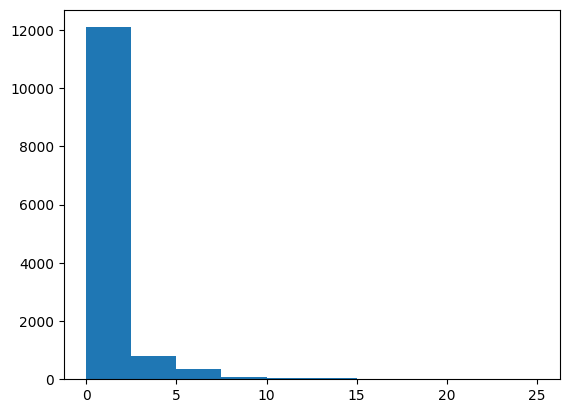

In [ ]:
plt.hist(df.groupby('Merchant City')['Merchant State'].nunique())

# 데이터 processing

## user

In [ ]:
user.head()

,Person,Current Age,Retirement Age,Birth Year,Birth Month,Gender,Address,Apartment,City,State,Zipcode,Latitude,Longitude,Per Capita Income - Zipcode,Yearly Income - Person,Total Debt,FICO Score,Num Credit Cards
0,Hazel Robinson,53,66,1966,11,Female,462 Rose Lane,NaN,La Verne,CA,91750,34.15,-117.76,$29278,$59696,$127613,787,5
1,Sasha Sadr,53,68,1966,12,Female,3606 Federal Boulevard,NaN,Little Neck,NY,11363,40.76,-73.74,$37891,$77254,$191349,701,5
2,Saanvi Lee,81,67,1938,11,Female,766 Third Drive,NaN,West Covina,CA,91792,34.02,-117.89,$22681,$33483,$196,698,5
3,Everlee Clark,63,63,1957,1,Female,3 Madison Street,NaN,New York,NY,10069,40.71,-73.99,$163145,$249925,$202328,722,4
4,Kyle Peterson,43,70,1976,9,Male,9620 Valley Stream Drive,NaN,San Francisco,CA,94117,37.76,-122.44,$53797,$109687,$183855,675,1


In [ ]:
user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 18 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Person                       2000 non-null   object 
 1   Current Age                  2000 non-null   int64  
 2   Retirement Age               2000 non-null   int64  
 3   Birth Year                   2000 non-null   int64  
 4   Birth Month                  2000 non-null   int64  
 5   Gender                       2000 non-null   object 
 6   Address                      2000 non-null   object 
 7   Apartment                    528 non-null    float64
 8   City                         2000 non-null   object 
 9   State                        2000 non-null   object 
 10  Zipcode                      2000 non-null   int64  
 11  Latitude                     2000 non-null   float64
 12  Longitude                    2000 non-null   float64
 13  Per Capita Income 

In [ ]:
percent_missing=(user.isnull().sum()*100/df.shape[0]).sort_values(ascending=True)
percent_missing

,0
Person,0.000000
Total Debt,0.000000
Yearly Income - Person,0.000000
Per Capita Income - Zipcode,0.000000
Longitude,0.000000
Latitude,0.000000
Zipcode,0.000000
State,0.000000
City,0.000000
Address,0.000000


In [ ]:
user['Person'].nunique()

1993

In [ ]:
user['Person'].value_counts()[user['Person'].value_counts() > 1].index

Index(['Hazel Robinson', 'Magdalena Farhad', 'Cassidy Anwar', 'Lochlan Morris',
       'Casey El-Mafouk', 'Abril Labelle', 'Rory Nelson'],
      dtype='object', name='Person')

In [ ]:
# 이름만 같은 다른 사람
user[user['Person'].isin(user['Person'].value_counts()[user['Person'].value_counts() > 1].index)]

,Person,Current Age,Retirement Age,Birth Year,Birth Month,Gender,Address,Apartment,City,State,Zipcode,Latitude,Longitude,Per Capita Income - Zipcode,Yearly Income - Person,Total Debt,FICO Score,Num Credit Cards
0,Hazel Robinson,53,66,1966,11,Female,462 Rose Lane,NaN,La Verne,CA,91750,34.15,-117.76,$29278,$59696,$127613,787,5
107,Lochlan Morris,56,56,1963,10,Male,336 Rose Avenue,NaN,Chicago,IL,60616,41.83,-87.68,$25365,$36335,$28929,676,2
245,Abril Labelle,18,63,2002,2,Female,345 George Avenue,922.0,Waynesboro,VA,22980,38.06,-78.90,$18531,$37785,$58187,748,1
259,Abril Labelle,52,61,1967,6,Female,4222 Ocean View Drive,NaN,Fort Knox,KY,40121,37.89,-85.96,$15879,$32378,$65919,588,4
269,Magdalena Farhad,36,68,1983,3,Female,28 Second Boulevard,6239.0,Lordsburg,NM,88045,32.34,-108.70,$15407,$31414,$42233,719,4
292,Lochlan Morris,47,63,1972,9,Male,857 Catherine Avenue,NaN,Boaz,AL,35957,34.20,-86.15,$14516,$29597,$44388,513,4
351,Cassidy Anwar,19,62,2000,11,Female,5378 Lafayette Avenue,NaN,Columbus,OH,43219,39.98,-82.98,$15539,$31683,$46987,817,4
422,Cassidy Anwar,28,70,1991,3,Female,19 El Camino Drive,1.0,Phoenix,AZ,85022,33.62,-112.05,$26023,$53053,$42396,696,2
448,Hazel Robinson,67,60,1952,11,Female,563 Birch Drive,NaN,Dacula,GA,30019,33.98,-83.88,$26767,$57705,$22475,684,3
458,Rory Nelson,54,67,1965,3,Female,401 North Avenue,6989.0,Lafayette,CO,80026,39.99,-105.09,$30072,$61312,$25355,708,3


In [ ]:
## Data preprocessing for user
user["User"] = range(2000) # create User ID to join with 'card'
user.head()

,Person,Current Age,Retirement Age,Birth Year,Birth Month,Gender,Address,Apartment,City,State,Zipcode,Latitude,Longitude,Per Capita Income - Zipcode,Yearly Income - Person,Total Debt,FICO Score,Num Credit Cards,User
0,Hazel Robinson,53,66,1966,11,Female,462 Rose Lane,NaN,La Verne,CA,91750,34.15,-117.76,$29278,$59696,$127613,787,5,0
1,Sasha Sadr,53,68,1966,12,Female,3606 Federal Boulevard,NaN,Little Neck,NY,11363,40.76,-73.74,$37891,$77254,$191349,701,5,1
2,Saanvi Lee,81,67,1938,11,Female,766 Third Drive,NaN,West Covina,CA,91792,34.02,-117.89,$22681,$33483,$196,698,5,2
3,Everlee Clark,63,63,1957,1,Female,3 Madison Street,NaN,New York,NY,10069,40.71,-73.99,$163145,$249925,$202328,722,4,3
4,Kyle Peterson,43,70,1976,9,Male,9620 Valley Stream Drive,NaN,San Francisco,CA,94117,37.76,-122.44,$53797,$109687,$183855,675,1,4


In [ ]:
## Remove the dollar signs
user["Yearly Income - Person"] = user["Yearly Income - Person"].str.replace("$", "").astype(float)
user["Yearly Income - Person"].head()

,Yearly Income - Person
0,59696.0
1,77254.0
2,33483.0
3,249925.0
4,109687.0


In [ ]:
user["Total Debt"] = user["Total Debt"].str.replace("$", "").astype(float)
user["Total Debt"].head()

,Total Debt
0,127613.0
1,191349.0
2,196.0
3,202328.0
4,183855.0


In [ ]:
user["User_Location_Income"] = user["Per Capita Income - Zipcode"].str.replace("$", "").astype(float)
user["User_Location_Income"].head()

,User_Location_Income
0,29278.0
1,37891.0
2,22681.0
3,163145.0
4,53797.0


In [ ]:
user['Retired'] = 'No'
user.loc[user['Current Age'] > user['Retirement Age'], 'Retired'] = 'Yes'
user['Retired'].head()

,Retired
0,No
1,No
2,Yes
3,No
4,No


In [ ]:
user['Person_Location_Income_ratio'] = user["Yearly Income - Person"]/(user["User_Location_Income"] + 0.01)
user['Person_Location_Income_ratio'].head()

,Person_Location_Income_ratio
0,2.038936
1,2.038848
2,1.476257
3,1.531919
4,2.038905


(array([1.989e+03, 1.000e+00, 2.000e+00, 1.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 1.000e+00, 1.000e+00, 4.000e+00]),
 array([6.72792506e-01, 2.46606055e+04, 4.93205382e+04, 7.39804710e+04,
        9.86404037e+04, 1.23300336e+05, 1.47960269e+05, 1.72620202e+05,
        1.97280135e+05, 2.21940067e+05, 2.46600000e+05]),
 <BarContainer object of 10 artists>)

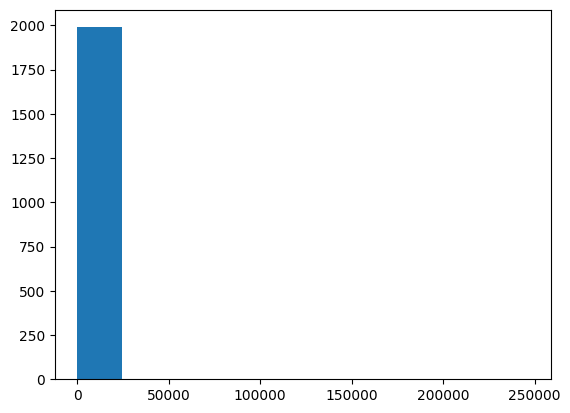

In [ ]:
plt.hist(user['Person_Location_Income_ratio'])

In [ ]:
user['Person_Income_toDebt'] = user["Yearly Income - Person"]/(user["Total Debt"] + 0.01)
user['Person_Income_toDebt'].head()

,Person_Income_toDebt
0,0.467789
1,0.403733
2,170.822917
3,1.235247
4,0.596595


(array([1.905e+03, 4.800e+01, 3.200e+01, 8.000e+00, 5.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([2.00857697e-01, 2.16740018e+06, 4.33480016e+06, 6.50220014e+06,
        8.66960012e+06, 1.08370001e+07, 1.30044001e+07, 1.51718001e+07,
        1.73392000e+07, 1.95066000e+07, 2.16740000e+07]),
 <BarContainer object of 10 artists>)

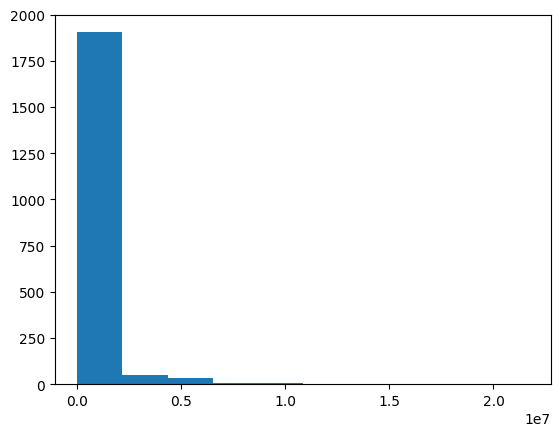

In [ ]:
plt.hist(user['Person_Income_toDebt'])

In [ ]:
user['Location_Income_toDebt'] = user["User_Location_Income"]/(user["Total Debt"] + 0.01)
user['Location_Income_toDebt'].head()

,Location_Income_toDebt
0,0.229428
1,0.198020
2,115.713484
3,0.806339
4,0.292606


(array([1.902e+03, 4.800e+01, 3.500e+01, 9.000e+00, 4.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([       0.,  1063050.,  2126100.,  3189150.,  4252200.,  5315250.,
         6378300.,  7441350.,  8504400.,  9567450., 10630500.]),
 <BarContainer object of 10 artists>)

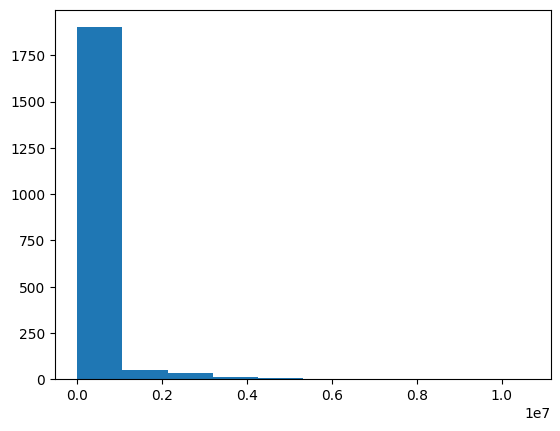

In [ ]:
plt.hist(user['Location_Income_toDebt'])

In [ ]:
user = user[['User', 'Gender', "Current Age", "Retired", "User_Location_Income", 'Yearly Income - Person', "Total Debt", "Num Credit Cards", 'Person_Location_Income_ratio','Person_Income_toDebt','Location_Income_toDebt']]
user.head()

,User,Gender,Current Age,Retired,User_Location_Income,Yearly Income - Person,Total Debt,Num Credit Cards,Person_Location_Income_ratio,Person_Income_toDebt,Location_Income_toDebt
0,0,Female,53,No,29278.0,59696.0,127613.0,5,2.038936,0.467789,0.229428
1,1,Female,53,No,37891.0,77254.0,191349.0,5,2.038848,0.403733,0.198020
2,2,Female,81,Yes,22681.0,33483.0,196.0,5,1.476257,170.822917,115.713484
3,3,Female,63,No,163145.0,249925.0,202328.0,4,1.531919,1.235247,0.806339
4,4,Male,43,No,53797.0,109687.0,183855.0,1,2.038905,0.596595,0.292606


## card

In [ ]:
card.head()

,User,CARD INDEX,Card Brand,Card Type,Card Number,Expires,CVV,Has Chip,Cards Issued,Credit Limit,Acct Open Date,Year PIN last Changed,Card on Dark Web
0,0,0,Visa,Debit,4344676511950444,12/2022,623,YES,2,$24295,09/2002,2008,No
1,0,1,Visa,Debit,4956965974959986,12/2020,393,YES,2,$21968,04/2014,2014,No
2,0,2,Visa,Debit,4582313478255491,02/2024,719,YES,2,$46414,07/2003,2004,No
3,0,3,Visa,Credit,4879494103069057,08/2024,693,NO,1,$12400,01/2003,2012,No
4,0,4,Mastercard,Debit (Prepaid),5722874738736011,03/2009,75,YES,1,$28,09/2008,2009,No


In [ ]:
card.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6146 entries, 0 to 6145
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   User                   6146 non-null   int64 
 1   CARD INDEX             6146 non-null   int64 
 2   Card Brand             6146 non-null   object
 3   Card Type              6146 non-null   object
 4   Card Number            6146 non-null   int64 
 5   Expires                6146 non-null   object
 6   CVV                    6146 non-null   int64 
 7   Has Chip               6146 non-null   object
 8   Cards Issued           6146 non-null   int64 
 9   Credit Limit           6146 non-null   object
 10  Acct Open Date         6146 non-null   object
 11  Year PIN last Changed  6146 non-null   int64 
 12  Card on Dark Web       6146 non-null   object
dtypes: int64(6), object(7)
memory usage: 624.3+ KB


(array([416., 388., 449., 376.,   0., 206., 105.,  40.,  17.,   3.]),
 array([1. , 1.8, 2.6, 3.4, 4.2, 5. , 5.8, 6.6, 7.4, 8.2, 9. ]),
 <BarContainer object of 10 artists>)

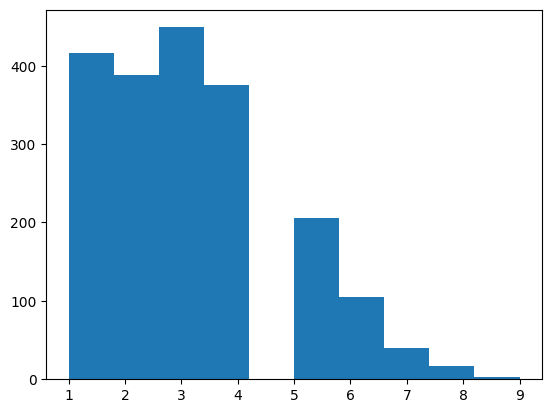

In [ ]:
plt.hist(card.groupby('User')['CARD INDEX'].nunique())

In [ ]:
card["User_Card"] = card['User'].astype(str) + '_' + card['CARD INDEX'].astype(str)
card["User_Card"].head()

,User_Card
0,0_0
1,0_1
2,0_2
3,0_3
4,0_4


In [ ]:
card["Credit Limit"] = card["Credit Limit"].str.replace("$", "").astype(float)
card["Credit Limit"].head()

,Credit Limit
0,24295.0
1,21968.0
2,46414.0
3,12400.0
4,28.0


In [ ]:
card = card[["User_Card", "User", 'Card Brand', "Card Type", "Credit Limit"]]
card.head()

,User_Card,User,Card Brand,Card Type,Credit Limit
0,0_0,0,Visa,Debit,24295.0
1,0_1,0,Visa,Debit,21968.0
2,0_2,0,Visa,Debit,46414.0
3,0_3,0,Visa,Credit,12400.0
4,0_4,0,Mastercard,Debit (Prepaid),28.0


In [ ]:
card = card.merge(user, on='User', how='left')
card = card.drop(columns=['User'])
card.head()

,User_Card,Card Brand,Card Type,Credit Limit,Gender,Current Age,Retired,User_Location_Income,Yearly Income - Person,Total Debt,Num Credit Cards,Person_Location_Income_ratio,Person_Income_toDebt,Location_Income_toDebt
0,0_0,Visa,Debit,24295.0,Female,53,No,29278.0,59696.0,127613.0,5,2.038936,0.467789,0.229428
1,0_1,Visa,Debit,21968.0,Female,53,No,29278.0,59696.0,127613.0,5,2.038936,0.467789,0.229428
2,0_2,Visa,Debit,46414.0,Female,53,No,29278.0,59696.0,127613.0,5,2.038936,0.467789,0.229428
3,0_3,Visa,Credit,12400.0,Female,53,No,29278.0,59696.0,127613.0,5,2.038936,0.467789,0.229428
4,0_4,Mastercard,Debit (Prepaid),28.0,Female,53,No,29278.0,59696.0,127613.0,5,2.038936,0.467789,0.229428


In [ ]:
del user

## df

In [ ]:
# Remove the dollar sign
df["Amount"] = df["Amount"].str.replace("$", "").astype(float)

In [ ]:
## Create the 'User_Card' index to join with crdit card information
df["User_Card"] = df['User'].astype(str) + '_' + df['Card'].astype(str)

In [ ]:
df[df['Amount'] <= 0].head()

,User,Card,Year,Month,Day,Time,Amount,Use Chip,Merchant Name,Merchant City,Merchant State,Zip,MCC,Errors?,Is Fraud?,User_Card
32,0,0,2002,9,11,13:17,-99.0,Swipe Transaction,2027553650310142703,Mira Loma,CA,91752.0,5541,NaN,No,0_0
72,0,0,2002,9,25,13:14,-100.0,Swipe Transaction,-1288082279022882052,La Verne,CA,91750.0,5499,NaN,No,0_0
116,0,0,2002,10,13,13:15,-99.0,Swipe Transaction,-1288082279022882052,La Verne,CA,91750.0,5499,NaN,No,0_0
122,0,0,2002,10,15,13:11,-88.0,Swipe Transaction,-4334232547381218591,Lincoln,NE,68521.0,5541,NaN,No,0_0
127,0,0,2002,10,16,11:54,-207.0,Swipe Transaction,7834055923142137930,Tilden,NE,68781.0,3395,NaN,No,0_0


In [ ]:
## Keep data with positive amount
df = df[df['Amount'] > 0]

In [ ]:
df = df.drop(columns=['User', 'Card', "Errors?", "Merchant Name", "Merchant State", "Zip", 'MCC'])

In [ ]:
df = df.merge(card, on='User_Card', how='left')

In [ ]:
df = df.merge(card, on='User_Card', how='left')
## Remove columns that will not be used
df = df.drop(columns=['User', 'Card', 'User_Card', "Errors?", "Merchant Name", "Merchant State", "Zip", 'MCC'])
df.head()

In [ ]:
del card

In [ ]:
## Create a column with combined transcation time
df["Transcation_Time"] = df["Year"].astype(str) + '-' + df["Month"].astype(str) + '-' + df["Day"].astype(str) + ' ' + df["Time"]
df["Transcation_Time"] = pd.to_datetime(df["Transcation_Time"])

## Day of the weel
df["Weekday"] = df["Transcation_Time"].dt.day_name()

## Split the time of day into 8 different periods based on hour
df['Time_of_Day'] = ''
df.loc[(df['Transcation_Time'].dt.hour >= 23) | (df['Transcation_Time'].dt.hour < 2), 'Time_of_Day'] = 'Midnight'
df.loc[(df['Transcation_Time'].dt.hour >= 2) & (df['Transcation_Time'].dt.hour < 5), 'Time_of_Day'] = 'Early Morning'
df.loc[(df['Transcation_Time'].dt.hour >= 5) & (df['Transcation_Time'].dt.hour < 8), 'Time_of_Day'] = 'Morning'
df.loc[(df['Transcation_Time'].dt.hour >= 8) & (df['Transcation_Time'].dt.hour < 11), 'Time_of_Day'] = 'Late Morning'
df.loc[(df['Transcation_Time'].dt.hour >= 11) & (df['Transcation_Time'].dt.hour < 14), 'Time_of_Day'] = 'Noon'
df.loc[(df['Transcation_Time'].dt.hour >= 14) & (df['Transcation_Time'].dt.hour < 17), 'Time_of_Day'] = 'Afternoon'
df.loc[(df['Transcation_Time'].dt.hour >= 17) & (df['Transcation_Time'].dt.hour < 20), 'Time_of_Day'] = 'Evening'
df.loc[(df['Transcation_Time'].dt.hour >= 20) & (df['Transcation_Time'].dt.hour < 23), 'Time_of_Day'] = 'Late Night'

## The last digit of the transaction amount can be a trait of fraud
df['last_digit'] = df['Amount'].astype(str).str[-1]
## Remove columns that will not be used
df = df.drop(columns=["Time", "Transcation_Time"])
## Show what the dataframe looks like after all the steps
df.head(10)